In [24]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt
import plotly.express as px
import plotly.graph_objects as go
import time
from datetime import datetime, timedelta






In [68]:
pd.set_option("display.max_rows", None) 
pd.set_option("display.max_columns", None)

In [86]:
#df = pd.read_json('/Users/barry/CodeAcademy/Sea_watch/sample_traces/2022_09_407637.json')
df = pd.read_json('sample_traces/2021_01_346401.json')

In [88]:
import os
import types

import cartopy.io.img_tiles as img_tiles
import requests
import PIL

class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.__func__, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'


plane: 342555
take_off: 2022-02-01 16:49:13


/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning:

invalid value encountered in buffer

/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning:

invalid value encountered in buffer



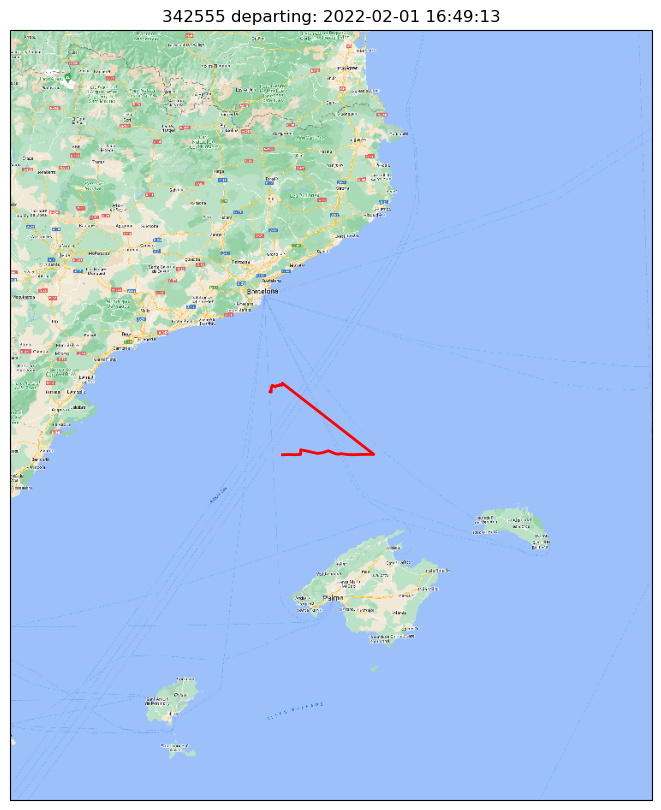

In [92]:
def route_maker(file_path):
    df = pd.read_json(file_path)

    if 'icao' in df.columns:
        icao = df.icao.unique()[0]
    elif 'hex' in df.columns:
        icao = df.hex.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    time_stamp = pd.to_datetime(time_stamp).round('1s')
    timeline = []
    latitude = []
    longitude = []
    altitude = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
   
    print(f'plane: {icao}\ntake_off: {time_stamp}')
    flight_info = zip(timeline, latitude, longitude, altitude)

    # Initialize our Google Maps tiles
    actual_tiler = cimgt.GoogleTiles()
    imagery = CachedTiler(actual_tiler)


    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(projection=ccrs.LambertConformal(central_longitude=0))
    plt.title(f'{icao} departing: {time_stamp}')

    # Set the boundaries around the map
    ax.set_extent([ 
        max(longitude) +2, min(longitude) - 2,
        min(latitude) -2 , max(latitude) +2
    ], crs=ccrs.Geodetic())

    # Draw the background
    ax.add_image(imagery, 9)

    # Draw the path of the fligt
    track = sgeom.LineString(zip(longitude,latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)    

route_maker('sample_highres_traces/2022_02_01_342555.json')



route_maker3 takes a file name and then creates an interative plotly map showing altitude as well as location

In [74]:
#I HAVE A PROBLEM WITH THE TIME
#this is for the normal traces NOT the high res
def route_maker3(json_name):
    df = pd.read_json(f'sample_traces/{json_name}.json')
    if 'icao' in df.columns:
        icao = df.icao.unique()[0]
    elif 'hex' in df.columns:
        icao = df.hex.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    time_stamp = pd.to_datetime(time_stamp).round('1s')
    #time_stamp = df.timestamp.unique()[0]
    timeline = []
    latitude = []
    longitude = []
    altitude = []
    track = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
        track.append(val[5])
    print(f'plane: {icao}\ntake_off: {time_stamp}')
    #flight_info = zip(timeline, latitude, longitude, altitude)

    

    df2 = pd.DataFrame({
    'Latitude': latitude,
    'Longitude': longitude,
    'Altitude': altitude,
    'Time': timeline,
    #I need to check if track is right
    'Track': track
    })
    df2['index'] = df2.index
    #I need the altitude to be an integer no Nulls or strings permitted
    df2.loc[df2.Altitude == 'ground', 'Altitude'] = 0
    df2.Altitude = df2.Altitude.fillna(0)
    df2['Altitude'] = df2['Altitude'].astype('int')

    df2['Time'] = df2['Time'].apply(lambda x: timedelta(seconds=x)) + time_stamp
    df2.loc[df2.Altitude == 'ground', 'Altitude'] = 0
    df2.Altitude = df2.Altitude.fillna(0)
    df2['Altitude'] = df2['Altitude'].astype('int')
    df2['Track_change'] = (df2['Track'].diff() +180)%360 -180

    
    #i want the time to be human readable
    # df2.Time = pd.to_timedelta(df2.Time) 
    # df2.Time = df2.Time + time_stamp


    # Plot flight path with altitude on a Mapbox map
    fig = px.scatter_mapbox(df2, 
                            lon='Longitude', 
                            lat='Latitude', 
                            color='Altitude', 
                            hover_data=['index', 'Longitude', 'Latitude','Time', 'Track', 'Track_change'], 
                         title=f'Flight {icao} take-off: {time_stamp}')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_traces(mode='markers+lines', line=dict(color='blue', width=2))
    fig.update_layout(height=800, width=1000) 

    fig.show()

route_maker3('2023_12_407637')

plane: 407637
take_off: 2023-12-01 00:00:00


In [92]:
# #I HAVE A PROBLEM WITH THE TIME
# #this is for the normal traces NOT the high res
# def hires_route_maker3(json_name):
#     df = pd.read_json(f'sample_highres_traces/{json_name}.json')
#     if 'icao' in df.columns:
#         icao = df.icao.unique()[0]
#     elif 'hex' in df.columns:
#         icao = df.hex.unique()[0]
#     time_stamp = df.timestamp.unique()[0]
#     timeline = []
#     latitude = []
#     longitude = []
#     altitude = []
#     track = []

#     for val in df.trace:
#         timeline.append(val[0])
#         latitude.append(val[1])
#         longitude.append(val[2])
#         altitude.append(val[3])
#         track.append(val[5])
#     print(f'plane: {icao}\ntake_off: {time_stamp}')
#     #flight_info = zip(timeline, latitude, longitude, altitude)

#     df2 = pd.DataFrame({
#     'Latitude': latitude,
#     'Longitude': longitude,
#     'Altitude': altitude,
#     'Time': timeline,
#     #I need to check if track is right
#     'Track': track
#     })
#     df2['index'] = df2.index
#     #I need the altitude to be an integer no Nulls or strings permitted
#     df2.loc[df2.Altitude == 'ground', 'Altitude'] = 0
#     df2.Altitude = df2.Altitude.fillna(0)
#     df2['Altitude'] = df2['Altitude'].astype('int')
    
#     #i want the time to be human readable
#     df2.Time = pd.to_timedelta(df2.Time) 
#     df2.Time = df2.Time + time_stamp


#     # Plot flight path with altitude on a Mapbox map
#     fig = px.scatter_mapbox(df2, 
#                             lon='Longitude', 
#                             lat='Latitude', 
#                             color='Altitude', 
#                             hover_data=['index', 'Longitude', 'Latitude','Time', 'Track'], 
#                          title=f'Flight {icao} take-off: {time_stamp}')
#     fig.update_layout(mapbox_style="open-street-map")
#     fig.update_traces(mode='markers+lines', line=dict(color='blue', width=2))
#     fig.update_layout(height=800, width=1000) 

#     fig.show()

# hires_route_maker3('2022_07_01_407637')

plane: 407637
take_off: 2022-07-01 05:38:09.936999936


## FUNCTION: route_maker2

The `route_maker2` function processes a JSON input representing a series of points in space, and generates a map of the route. Additionally, it features the ability to track directional changes between points. If the cumulative directional change adds up to 360 degrees, it indicates that the plane has completed a full rotation.

### Functionality:

1. **Input:**
   - The function takes a JSON object as input

2. **Mapping:**
   - The primary functionality involves mapping the points provided in the JSON

3. **Directional Change Tracking:**
   - The function keeps track of directional changes between consecutive points.

4. **360-Degree Rotation Detection:**
   - If the cumulative change between given points exceeds 360 degrees it means it has completed an 'orbit' in that time period

### To be checked
1. **anti-clockwise**
   -Does it work both directions -I think it does but need to check
2. **way to track the number of orbits**


In [84]:
# i believe time is working now
def route_maker2(json_name):
    df = pd.read_json(json_name)
    #df = pd.read_json(f'sample_highres_traces/{json_name}.json')
    if 'icao' in df.columns:
        icao = df.icao.unique()[0]
    elif 'hex' in df.columns:
        icao = df.hex.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    time_stamp = pd.to_datetime(time_stamp).round('1s')

#i can neeten this by creating an empty DF and then populating it with the df.trace info
    timeline = []
    latitude = []
    longitude = []
    altitude = []
    track = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
        track.append(val[5])
    print(f'plane: {icao}\ntake_off: {time_stamp}')

    df2 = pd.DataFrame({
    'Latitude': latitude,
    'Longitude': longitude,
    'Altitude': altitude,
    'Time': timeline,
    'Track': track
    })
    df2['index'] = df2.index
    #I need the altitude to be an integer no Nulls or strings permitted
    df2.loc[df2.Altitude == 'ground', 'Altitude'] = 0

    df2.Altitude = df2.Altitude.fillna(0)
    df2['Altitude'] = df2['Altitude'].astype('int')
    #I no longer remember my logic here. but it is a way of dealing with passing between 0 and 360
    df2['Track_change'] = (df2['Track'].diff() +180)%360 -180


    
    #i want the time to be human readable
    #df2.Time = pd.to_timedelta(df2.Time) 
    #df2.Time = timedelta(seconds = df2.Time) + time_stamp
    df2['Time'] = df2['Time'].apply(lambda x: timedelta(seconds=x)) + time_stamp
    print(df2.head())

    #sometimes values are mising which makes the caluclation for change from previous row difficult. Getting rid of it seems like a good solution.
    df2= df2.dropna()



    # Plot flight path with altitude on a Mapbox map
    fig = px.scatter_mapbox(df2, 
                            lon='Longitude', 
                            lat='Latitude', 
                            color='Altitude', 
                            hover_data=['index', 'Longitude', 'Latitude','Time', 'Track', 'Track_change'], 
                         title=f'Flight {icao} take-off: {time_stamp}')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_traces(mode='markers+lines', line=dict(color='blue', width=2))
    fig.update_layout(height=800, width=1000) 

    fig.show()
    #valid for sample_traces/2022_07_407637.json
    # df_scrap2 = df2.loc[687:788]
    # display(df_scrap2.head(1))
    # display(df_scrap2.tail(1))
    # display(df_scrap2.Track_change.sum())


    #display(df_scrap.Track_change.sum())
    
  

route_maker2('sample_traces/2022_07_407637.json')

plane: 407637
take_off: 2022-07-01 05:38:10
    Latitude  Longitude  Altitude                    Time  Track  index  \
0  35.388748  12.499180      3100 2022-07-01 05:38:10.000  216.4      0   
1  35.387335  12.497825      3125 2022-07-01 05:38:13.500  216.4      1   
2  35.380166  12.491338      3300 2022-07-01 05:38:32.100  216.4      2   
3  35.376256  12.487715      3375 2022-07-01 05:38:41.700  217.1      3   
4  35.375046  12.486663      3400 2022-07-01 05:38:44.700  217.1      4   

   Track_change  
0           NaN  
1           0.0  
2           0.0  
3           0.7  
4           0.0  


Latitude  Longitude  Altitude                    Time  Track  index  \
687  34.478124  11.531754      5000 2022-07-01 08:05:38.600  305.1    687   

     Track_change  
687          -5.6

Latitude  Longitude  Altitude                    Time  Track  index  \
788  34.454009  11.537762      5000 2022-07-01 08:15:29.500    1.0    788   

     Track_change  
788           0.0

-669.7000000000002